In [34]:
from datetime import date
import silverfund.data_access_layer as dal
from silverfund.enums import Interval
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
# Load CRSP daily data
start_date = date(1995, 7, 31)
end_date = date(2024, 12, 31)
crsp_daily = dal.load_crsp(interval=Interval.DAILY, start_date=start_date, end_date=end_date)
print(crsp_daily)

NameError: name 'date' is not defined

**EXERCISE 1**

In [ ]:
# Ensure data is sorted for rolling calculations
crsp_daily = crsp_daily.sort(["permno", "date"])

# Compute log returns
crsp_daily_log = crsp_daily.with_columns((pl.col("ret") + 1).log().alias("log_ret"))
print(crsp_daily_log)

shape: (56_500_937, 15)
┌────────┬────────┬────────────┬──────────┬───┬─────────────┬───────────┬─────────┬───────────┐
│ permno ┆ permco ┆ date       ┆ ncusip   ┆ … ┆ vol         ┆ shrout    ┆ cfacshr ┆ log_ret   │
│ ---    ┆ ---    ┆ ---        ┆ ---      ┆   ┆ ---         ┆ ---       ┆ ---     ┆ ---       │
│ i64    ┆ i64    ┆ date       ┆ str      ┆   ┆ f64         ┆ f64       ┆ f64     ┆ f64       │
╞════════╪════════╪════════════╪══════════╪═══╪═════════════╪═══════════╪═════════╪═══════════╡
│ 10001  ┆ 7953   ┆ 1995-07-31 ┆ 29274A10 ┆ … ┆ 400.0       ┆ 2254.0    ┆ 1.5     ┆ 0.030772  │
│ 10001  ┆ 7953   ┆ 1995-08-01 ┆ 29274A10 ┆ … ┆ 0.0         ┆ 2254.0    ┆ 1.5     ┆ -0.015268 │
│ 10001  ┆ 7953   ┆ 1995-08-02 ┆ 29274A10 ┆ … ┆ 300.0       ┆ 2254.0    ┆ 1.5     ┆ 0.015268  │
│ 10001  ┆ 7953   ┆ 1995-08-03 ┆ 29274A10 ┆ … ┆ 250.0       ┆ 2254.0    ┆ 1.5     ┆ -0.06252  │
│ 10001  ┆ 7953   ┆ 1995-08-04 ┆ 29274A10 ┆ … ┆ 100.0       ┆ 2254.0    ┆ 1.5     ┆ 0.06252   │
│ …      ┆ …    

In [ ]:
# Ensure data is sorted by date for rolling calculations
crsp_daily_log = crsp_daily_log.sort(["permno", "date"])

# Compute rolling momentum signal (log return sum over past 230 days)
momentum_signal = crsp_daily_log.with_columns(
    pl.col("log_ret").rolling_sum(window_size=230).over("permno").alias("momentum_signal")
)

# Apply 22-day shift for look-ahead bias correction
momentum_signal = momentum_signal.with_columns(
    pl.col("momentum_signal").shift(22).over("permno")
).drop_nulls()

# Pivot to make permno columns and date rows
momentum_wide = momentum_signal.pivot(index="date", on="permno", values="momentum_signal")
print(momentum_wide)

shape: (7_156, 25_204)
┌────────────┬──────────┬──────────┬──────────┬───┬───────┬───────────┬───────┬──────────┐
│ date       ┆ 10001    ┆ 10002    ┆ 10009    ┆ … ┆ 93433 ┆ 93434     ┆ 93435 ┆ 93436    │
│ ---        ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---   ┆ ---       ┆ ---   ┆ ---      │
│ date       ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64   ┆ f64       ┆ f64   ┆ f64      │
╞════════════╪══════════╪══════════╪══════════╪═══╪═══════╪═══════════╪═══════╪══════════╡
│ 1996-07-26 ┆ 0.076755 ┆ 0.045228 ┆ 0.137668 ┆ … ┆ null  ┆ null      ┆ null  ┆ null     │
│ 1996-07-29 ┆ 0.045983 ┆ 0.091319 ┆ 0.098991 ┆ … ┆ null  ┆ null      ┆ null  ┆ null     │
│ 1996-07-30 ┆ 0.061251 ┆ 0.054618 ┆ 0.065564 ┆ … ┆ null  ┆ null      ┆ null  ┆ null     │
│ 1996-07-31 ┆ 0.015212 ┆ 0.091319 ┆ 0.090257 ┆ … ┆ null  ┆ null      ┆ null  ┆ null     │
│ 1996-08-01 ┆ 0.108504 ┆ 0.091319 ┆ 0.112861 ┆ … ┆ null  ┆ null      ┆ null  ┆ null     │
│ …          ┆ …        ┆ …        ┆ …        ┆ … ┆ …     ┆ …      

**EXERCISE 2**

In [ ]:
# Assign deciles based on momentum signal within each date
labels = [str(x) for x in range(1, 11)]  # 1 to 10

momentum_deciles = momentum_signal.with_columns(
    pl.col("momentum_signal").qcut(10, labels=labels).over("date").alias("decile")
)

# Display first few rows of the decile assignment
print(momentum_deciles)

shape: (49_709_250, 17)
┌────────┬────────┬────────────┬──────────┬───┬─────────┬───────────┬─────────────────┬────────┐
│ permno ┆ permco ┆ date       ┆ ncusip   ┆ … ┆ cfacshr ┆ log_ret   ┆ momentum_signal ┆ decile │
│ ---    ┆ ---    ┆ ---        ┆ ---      ┆   ┆ ---     ┆ ---       ┆ ---             ┆ ---    │
│ i64    ┆ i64    ┆ date       ┆ str      ┆   ┆ f64     ┆ f64       ┆ f64             ┆ cat    │
╞════════╪════════╪════════════╪══════════╪═══╪═════════╪═══════════╪═════════════════╪════════╡
│ 10001  ┆ 7953   ┆ 1996-07-26 ┆ 29274A10 ┆ … ┆ 1.5     ┆ 0.0       ┆ 0.076755        ┆ 5      │
│ 10001  ┆ 7953   ┆ 1996-07-29 ┆ 29274A10 ┆ … ┆ 1.5     ┆ 0.007663  ┆ 0.045983        ┆ 4      │
│ 10001  ┆ 7953   ┆ 1996-07-30 ┆ 29274A10 ┆ … ┆ 1.5     ┆ 0.022643  ┆ 0.061251        ┆ 5      │
│ 10001  ┆ 7953   ┆ 1996-07-31 ┆ 29274A10 ┆ … ┆ 1.5     ┆ -0.022642 ┆ 0.015212        ┆ 4      │
│ 10001  ┆ 7953   ┆ 1996-08-01 ┆ 29274A10 ┆ … ┆ 1.5     ┆ -0.023167 ┆ 0.108504        ┆ 5      │
│ …   

In [ ]:
# Validate decile distribution
decile_distribution = momentum_deciles.group_by(["date", "decile"]).agg(
    pl.col("permno").count().alias("num_stocks")
)  # .select('num_stocks').describe()
print(decile_distribution)

shape: (71_560, 3)
┌────────────┬────────┬────────────┐
│ date       ┆ decile ┆ num_stocks │
│ ---        ┆ ---    ┆ ---        │
│ date       ┆ cat    ┆ u32        │
╞════════════╪════════╪════════════╡
│ 2017-02-01 ┆ 8      ┆ 673        │
│ 2006-04-05 ┆ 3      ┆ 621        │
│ 2009-01-16 ┆ 9      ┆ 642        │
│ 2012-02-23 ┆ 7      ┆ 620        │
│ 2012-10-15 ┆ 6      ┆ 626        │
│ …          ┆ …      ┆ …          │
│ 1998-12-22 ┆ 9      ┆ 802        │
│ 2002-10-08 ┆ 1      ┆ 678        │
│ 2005-09-01 ┆ 5      ┆ 622        │
│ 2022-03-24 ┆ 9      ┆ 785        │
│ 2024-05-15 ┆ 10     ┆ 854        │
└────────────┴────────┴────────────┘


In [ ]:
# Step 1: Filter stocks in top and bottom deciles
top_decile = momentum_deciles.filter(pl.col("decile").cast(pl.Int32) == 10)
bottom_decile = momentum_deciles.filter(pl.col("decile").cast(pl.Int32) == 1)

# Step 2: Merge with returns data to get stock returns
top_decile_returns = top_decile.join(crsp_daily_log, on=["permno", "date"], how="inner").select(
    ["date", "permno", "log_ret"]
)
bottom_decile_returns = bottom_decile.join(
    crsp_daily_log, on=["permno", "date"], how="inner"
).select(["date", "permno", "log_ret"])

# Step 3: Compute equal-weighted portfolio returns
top_portfolio = top_decile_returns.group_by("date").agg(
    pl.col("log_ret").mean().alias("top_portfolio_return")
)

bottom_portfolio = bottom_decile_returns.group_by("date").agg(
    pl.col("log_ret").mean().alias("bottom_portfolio_return")
)

# Merge both portfolios into a single DataFrame
portfolio_returns = top_portfolio.join(bottom_portfolio, on="date", how="inner")

# Compute long-short portfolio returns
long_short_portfolio = portfolio_returns.with_columns(
    (pl.col("top_portfolio_return") - pl.col("bottom_portfolio_return")).alias("long_short_return")
)

print(long_short_portfolio)

shape: (7_156, 4)
┌────────────┬──────────────────────┬─────────────────────────┬───────────────────┐
│ date       ┆ top_portfolio_return ┆ bottom_portfolio_return ┆ long_short_return │
│ ---        ┆ ---                  ┆ ---                     ┆ ---               │
│ date       ┆ f64                  ┆ f64                     ┆ f64               │
╞════════════╪══════════════════════╪═════════════════════════╪═══════════════════╡
│ 2015-08-05 ┆ 0.006935             ┆ -0.016532               ┆ 0.023467          │
│ 2015-12-14 ┆ -0.005768            ┆ -0.033995               ┆ 0.028226          │
│ 2023-06-23 ┆ -0.012972            ┆ -0.014695               ┆ 0.001723          │
│ 2005-11-22 ┆ 0.007882             ┆ 0.002715                ┆ 0.005167          │
│ 2022-10-04 ┆ 0.024593             ┆ 0.046439                ┆ -0.021845         │
│ …          ┆ …                    ┆ …                       ┆ …                 │
│ 2011-04-07 ┆ -0.003164            ┆ -0.001791           

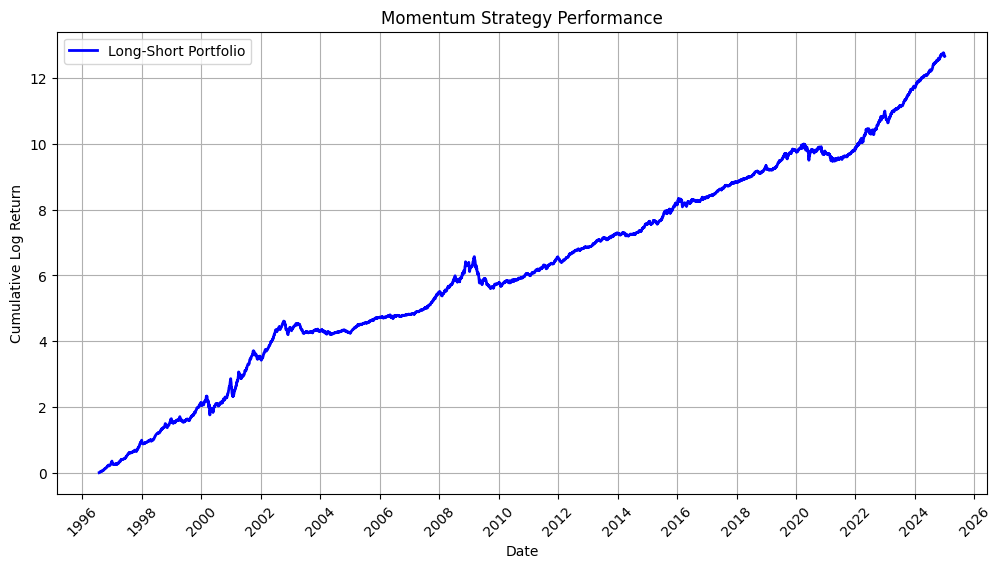

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Sort data by date to ensure proper plotting
long_short_portfolio = long_short_portfolio.sort("date")

# Extract data from Polars DataFrame
dates = long_short_portfolio["date"].to_list()
long_short_cumsum = long_short_portfolio["long_short_return"].cum_sum().to_list()
top_cumsum = long_short_portfolio["top_portfolio_return"].cum_sum().to_list()
bottom_cumsum = long_short_portfolio["bottom_portfolio_return"].cum_sum().to_list()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(dates, long_short_cumsum, label="Long-Short Portfolio", linewidth=2, color="blue")
# plt.plot(dates, top_cumsum, label="Top Decile Portfolio", linestyle="dashed", color="orange")
# plt.plot(dates, bottom_cumsum, label="Bottom Decile Portfolio", linestyle="dotted", color="green")

# Formatting
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.title("Momentum Strategy Performance")
plt.legend()
plt.grid(True)

# Improve date formatting
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Show every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Show the plot
plt.show()

YAY! I DID IT!

**Exercise 3**

In [ ]:
import silverfund.portfolios as mveport

# Step 1: Set ICi,t+1 = 0.05 for all stocks and dates
momentum_signal = momentum_signal.with_columns(pl.lit(0.05).alias("IC"))

# Step 2: Compute cross-sectional mean and standard deviation for each date
z_scores = momentum_signal.group_by("date").agg(
    [
        pl.col("momentum_signal").mean().alias("mean_signal"),
        pl.col("momentum_signal").std().alias("std_signal"),
    ]
)

# Merge Z-score calculations back into momentum_signal
momentum_signal = momentum_signal.join(z_scores, on="date", how="left")

# Compute Z-score
momentum_signal = momentum_signal.with_columns(
    ((pl.col("momentum_signal") - pl.col("mean_signal")) / pl.col("std_signal")).alias("Z_score")
)

# Step 3: Compute alpha values for each stock
momentum_signal = momentum_signal.with_columns((pl.col("IC") * pl.col("Z_score")).alias("alpha"))

# Step 4: Compute the self-financed portfolio weights
portfolio_weights = momentum_signal.group_by("date").agg(
    [pl.col("alpha").abs().sum().alias("sum_abs_alpha")]
)

# Merge sum_abs_alpha back into momentum_signal
momentum_signal = momentum_signal.join(portfolio_weights, on="date", how="left")

# Compute self-financed portfolio weights
momentum_signal = momentum_signal.with_columns(
    (pl.col("alpha") / pl.col("sum_abs_alpha")).alias("portfolio_weight")
)

In [ ]:
# Print sample of computed Z-scores
print(momentum_signal.select(["date", "permno", "momentum_signal", "Z_score"]))

shape: (49_709_250, 4)
┌────────────┬────────┬─────────────────┬───────────┐
│ date       ┆ permno ┆ momentum_signal ┆ Z_score   │
│ ---        ┆ ---    ┆ ---             ┆ ---       │
│ date       ┆ i64    ┆ f64             ┆ f64       │
╞════════════╪════════╪═════════════════╪═══════════╡
│ 1996-07-26 ┆ 10001  ┆ 0.076755        ┆ -0.048598 │
│ 1996-07-29 ┆ 10001  ┆ 0.045983        ┆ -0.091817 │
│ 1996-07-30 ┆ 10001  ┆ 0.061251        ┆ -0.064251 │
│ 1996-07-31 ┆ 10001  ┆ 0.015212        ┆ -0.191255 │
│ 1996-08-01 ┆ 10001  ┆ 0.108504        ┆ 0.003675  │
│ …          ┆ …      ┆ …               ┆ …         │
│ 2024-12-24 ┆ 93436  ┆ 0.296319        ┆ 0.503071  │
│ 2024-12-26 ┆ 93436  ┆ 0.317666        ┆ 0.530859  │
│ 2024-12-27 ┆ 93436  ┆ 0.258587        ┆ 0.436514  │
│ 2024-12-30 ┆ 93436  ┆ 0.289628        ┆ 0.485287  │
│ 2024-12-31 ┆ 93436  ┆ 0.292452        ┆ 0.476013  │
└────────────┴────────┴─────────────────┴───────────┘


In [ ]:
# Print sample of alpha values
print(momentum_signal.select(["date", "permno", "Z_score", "IC", "alpha"]))

shape: (49_709_250, 5)
┌────────────┬────────┬───────────┬──────┬───────────┐
│ date       ┆ permno ┆ Z_score   ┆ IC   ┆ alpha     │
│ ---        ┆ ---    ┆ ---       ┆ ---  ┆ ---       │
│ date       ┆ i64    ┆ f64       ┆ f64  ┆ f64       │
╞════════════╪════════╪═══════════╪══════╪═══════════╡
│ 1996-07-26 ┆ 10001  ┆ -0.048598 ┆ 0.05 ┆ -0.00243  │
│ 1996-07-29 ┆ 10001  ┆ -0.091817 ┆ 0.05 ┆ -0.004591 │
│ 1996-07-30 ┆ 10001  ┆ -0.064251 ┆ 0.05 ┆ -0.003213 │
│ 1996-07-31 ┆ 10001  ┆ -0.191255 ┆ 0.05 ┆ -0.009563 │
│ 1996-08-01 ┆ 10001  ┆ 0.003675  ┆ 0.05 ┆ 0.000184  │
│ …          ┆ …      ┆ …         ┆ …    ┆ …         │
│ 2024-12-24 ┆ 93436  ┆ 0.503071  ┆ 0.05 ┆ 0.025154  │
│ 2024-12-26 ┆ 93436  ┆ 0.530859  ┆ 0.05 ┆ 0.026543  │
│ 2024-12-27 ┆ 93436  ┆ 0.436514  ┆ 0.05 ┆ 0.021826  │
│ 2024-12-30 ┆ 93436  ┆ 0.485287  ┆ 0.05 ┆ 0.024264  │
│ 2024-12-31 ┆ 93436  ┆ 0.476013  ┆ 0.05 ┆ 0.023801  │
└────────────┴────────┴───────────┴──────┴───────────┘


In [ ]:
# Print sample of portfolio weights
print(momentum_signal.select(["date", "permno", "alpha", "portfolio_weight"]))

shape: (49_709_250, 4)
┌────────────┬────────┬───────────┬──────────────────┐
│ date       ┆ permno ┆ alpha     ┆ portfolio_weight │
│ ---        ┆ ---    ┆ ---       ┆ ---              │
│ date       ┆ i64    ┆ f64       ┆ f64              │
╞════════════╪════════╪═══════════╪══════════════════╡
│ 1996-07-26 ┆ 10001  ┆ -0.00243  ┆ -0.00001         │
│ 1996-07-29 ┆ 10001  ┆ -0.004591 ┆ -0.000018        │
│ 1996-07-30 ┆ 10001  ┆ -0.003213 ┆ -0.000013        │
│ 1996-07-31 ┆ 10001  ┆ -0.009563 ┆ -0.000037        │
│ 1996-08-01 ┆ 10001  ┆ 0.000184  ┆ 7.1569e-7        │
│ …          ┆ …      ┆ …         ┆ …                │
│ 2024-12-24 ┆ 93436  ┆ 0.025154  ┆ 0.000103         │
│ 2024-12-26 ┆ 93436  ┆ 0.026543  ┆ 0.000109         │
│ 2024-12-27 ┆ 93436  ┆ 0.021826  ┆ 0.00009          │
│ 2024-12-30 ┆ 93436  ┆ 0.024264  ┆ 0.000099         │
│ 2024-12-31 ┆ 93436  ┆ 0.023801  ┆ 0.000098         │
└────────────┴────────┴───────────┴──────────────────┘


In [ ]:
# Step 1: Merge portfolio weights with stock returns
weighted_returns = momentum_signal.join(
    crsp_daily_log, on=["permno", "date"], how="inner"
).with_columns((pl.col("portfolio_weight") * pl.col("log_ret")).alias("weighted_return"))

# Step 2: Aggregate weighted returns to get portfolio return
portfolio_performance = weighted_returns.group_by("date").agg(
    pl.col("weighted_return").sum().alias("portfolio_log_return")
)

# Step 3: Compute cumulative log returns
portfolio_performance = portfolio_performance.with_columns(
    pl.col("portfolio_log_return").cum_sum().alias("cumulative_log_return")
)

# Step 4: Convert daily returns to monthly returns
portfolio_performance_monthly = (
    portfolio_performance.group_by(pl.col("date").dt.truncate("1mo"))  # Aggregate to monthly level
    .agg(pl.col("portfolio_log_return").sum().alias("monthly_log_return"))
    .sort("date")  # Ensure sorting
)

# Step 5: Compute cumulative log returns at the monthly level
portfolio_performance_monthly = portfolio_performance_monthly.with_columns(
    pl.col("monthly_log_return").cum_sum().alias("cumulative_monthly_return")
)

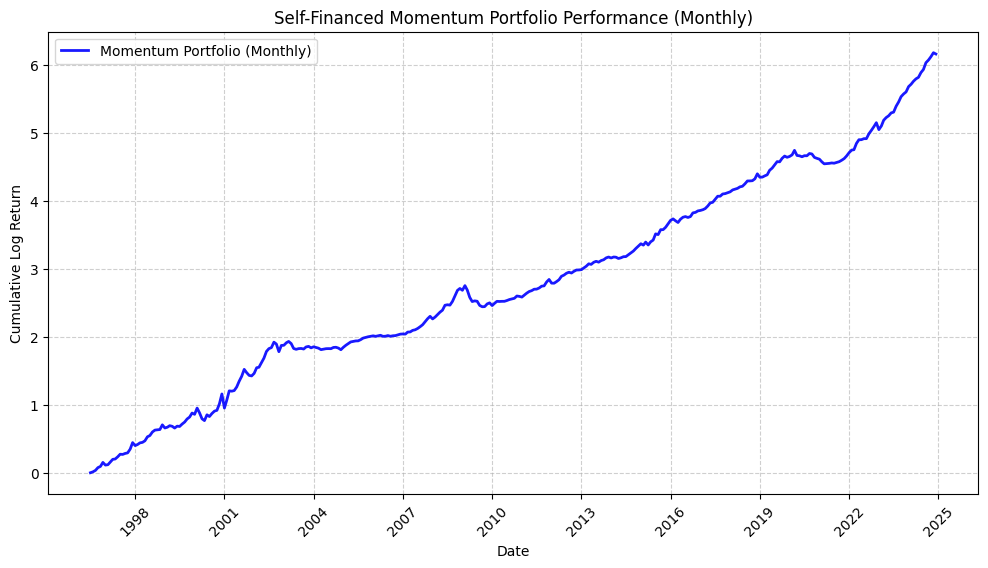

In [ ]:
# Extract data for plotting
dates = portfolio_performance_monthly["date"].to_list()
cumulative_returns = portfolio_performance_monthly["cumulative_monthly_return"].to_list()

# Step 6: Plot the cumulative log returns (now at monthly level)
plt.figure(figsize=(12, 6))
plt.plot(
    dates,
    cumulative_returns,
    label="Momentum Portfolio (Monthly)",
    linewidth=2,
    color="blue",
    alpha=0.9,
)

# Formatting
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.title("Self-Financed Momentum Portfolio Performance (Monthly)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Improve x-axis formatting (show every 3 years)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Show the plot
plt.show()